In [ ]:
import os
import subprocess
num_processors = 8
input_path ='/global/cfs/projectdirs/m3845/Diego_projects/AIMD-siesta/tutorials/Phonons/GaAs-2D - first-calculation/' #'/global/cfs/projectdirs/m3845/Diego_projects/AIMD-siesta/tutorials/Phonons/GaAs-2D/'#'/global/cfs/projectdirs/m3845/Diego_projects/AIMD-siesta/tutorials/Phonons/GaAs-2D/'
siesta_exec = "/global/homes/d/dajuarez/.conda/envs/siesta_env/bin/siesta"
os.environ["PATH"] = os.path.dirname(siesta_exec) + ":" + os.environ.get("PATH", "")
os.chdir(input_path)

build_file = 'GaAs-2D.fcbuild.fdf'
int_atom_fc_file ='GaAs-2D.ifc.fdf'

# # #create force cte
# cmd2 = f'fcbuild < {build_file} | tee build.log'
# subprocess.run(cmd2, shell=True, check=True)

## before run this copy blocks from .FC file
cmd3 = f" mpirun -np {num_processors} {siesta_exec} < {int_atom_fc_file} > GaAs.ifc.log"
subprocess.run(cmd3, shell=True, check=True)

# # #then run vibra to generate the .bands file 
# cmd4 = f'   vibra < {build_file} > vibra.out'#mpirun -np {num_processors}
# subprocess.run(cmd4 , shell=True, check=True, cwd=input_path)

# cmd5 = 'gnubands  < 2D-GaAs-GGA-RL.bands > 2D-GaAs.phonon-bands.111.dat'
# subprocess.run(cmd5, shell=True, check=True)

--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           login03
  Local device:         mlx5_bond_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------
[login03:2353910] 7 more processes have sent help message help-mpi-btl-openib-cpc-base.txt / no cpcs for port
[login03:2353910] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


Saved: /global/cfs/cdirs/m3845/Diego_projects/AIMD-siesta/tutorials/Phonons/GaAs-2D/results_fourt_try/bands_plot.png
Saved: /global/cfs/cdirs/m3845/Diego_projects/AIMD-siesta/tutorials/Phonons/GaAs-2D/results_fourt_try/bands_plot.svg


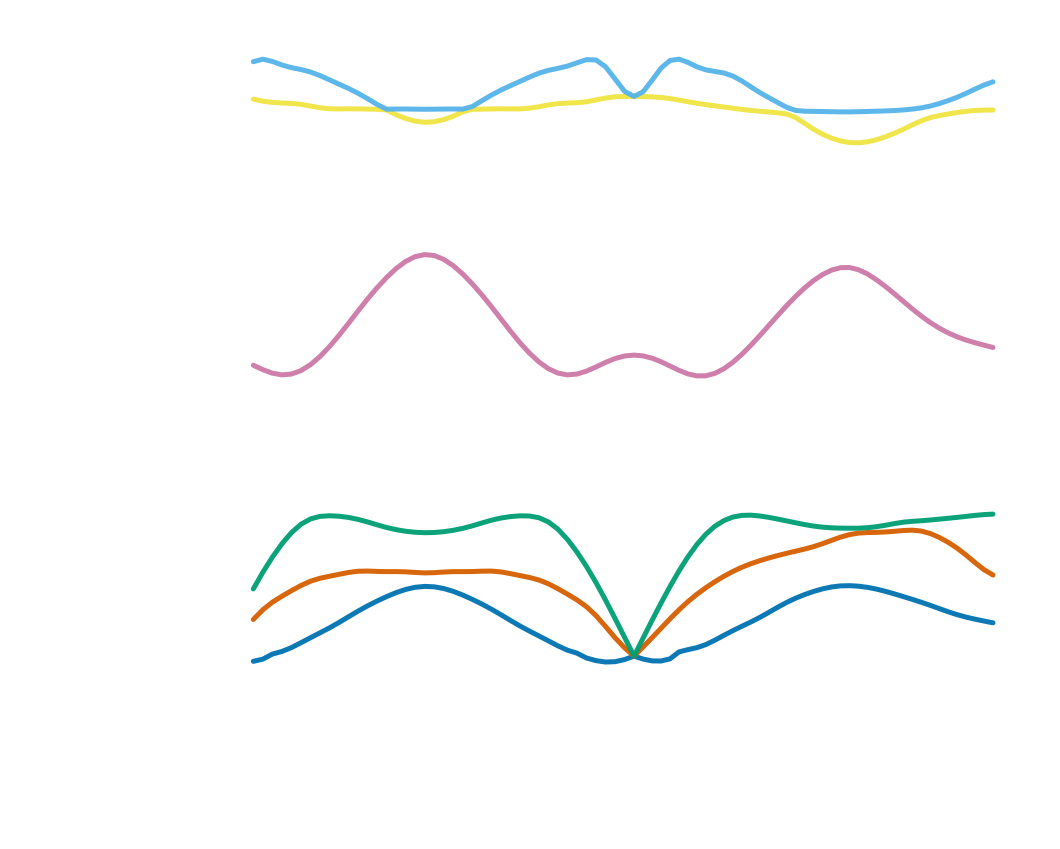

In [7]:
#!/usr/bin/env python3
# Plot GNUBANDS con colores por rama, fondo transparente, texto blanco
# y ejes k etiquetados según %block BandLines (M -> Γ -> K)

import sys, math
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

# -------- CONFIG --------
INPUT_PATH  = Path("2D-GaAs.phonon-bands.111.dat")
OUTPUT_PNG  = Path("bands_plot.png")   # PNG con fondo transparente
OUTPUT_SVG  = Path("bands_plot.svg")   # SVG sin fondo
line_w      = 1.2
alpha       = 0.95
TEXT_COLOR  = "white"
OKABE_ITO = ["#0072B2","#D55E00","#009E73","#CC79A7",
             "#F0E442","#56B4E9","#E69F00","#000000"]

# --- K-path para etiquetas, en el orden de tus tramos ---
# (n_puntos, (kx,ky,kz), etiqueta)  -> sólo usamos n_puntos y etiqueta
BANDLINES = [
    (1,   (0.5,  0.0,  0.0),  "M"),          # Start at M
    (40,  (0.0,  0.0,  0.0),  r"$\Gamma$"),  # M -> Γ
    (40,  (1/3,  1/3,  0.0),  "K"),          # Γ -> K
]

# ---------- Helpers ----------
def parse_blocks(text: str):
    """Divide el archivo en segmentos (k, E) por líneas en blanco/no numéricas."""
    segments, current = [], []
    for raw in text.splitlines():
        s = raw.strip()
        if not s or s.startswith('#') or set(s) == {'-'}:
            if current:
                segments.append(current); current = []
            continue
        vals=[]
        for p in s.split():
            try: vals.append(float(p))
            except ValueError: pass
        if len(vals) >= 2 and math.isfinite(vals[0]) and math.isfinite(vals[1]):
            current.append((vals[0], vals[1]))
        else:
            if current:
                segments.append(current); current = []
    if current: segments.append(current)
    return segments

def load_text(path: Path) -> str:
    if path.exists(): return path.read_text(encoding="utf-8", errors="ignore")
    if not sys.stdin.isatty(): return sys.stdin.read()
    raise FileNotFoundError(f"Missing '{path}'. Proporciona el archivo o usa stdin.")

# ---------- Main ----------
def main():
    text = load_text(INPUT_PATH)
    segments = parse_blocks(text)
    if not segments:
        raise RuntimeError("No se encontraron segmentos numéricos (k, E).")

    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300,
        "font.size": 10, "axes.labelsize": 11,
        "xtick.labelsize": 9, "ytick.labelsize": 9,
        "axes.spines.top": False, "axes.spines.right": False,
        "axes.linewidth": 1.0, "mathtext.default": "regular",
        "text.color": TEXT_COLOR,
        "axes.labelcolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
    })

    fig, ax = plt.subplots(figsize=(3.8, 2.9))

    fig.patch.set_alpha(0.0)
    ax.set_facecolor("none")

    for side in ("left","bottom","right","top"):
        ax.spines[side].set_color(TEXT_COLOR)
    ax.tick_params(colors=TEXT_COLOR, direction="out", length=3.5, width=0.8)

    ax.set_prop_cycle(color=OKABE_ITO)

    for seg in segments:
        ks = [p[0] for p in seg]
        # Si ya está en eV, usa: Es = [p[1] for p in seg]
        Es = [p[1]/241.764 for p in seg]
        ax.plot(ks, Es, lw=line_w, alpha=alpha,
                solid_joinstyle="round", solid_capstyle="round")

    ax.axhline(0.0, ls="--", lw=0.9, color=TEXT_COLOR, alpha=0.6, zorder=0)
    ax.set_ylabel(r"$E$ (eV)")

    counts  = [b[0] for b in BANDLINES]          
    labels  = [b[2] for b in BANDLINES]         

    ks_master = [p[0] for p in segments[0]]      # malla k del primer segmento
    total_needed = sum(counts)

    if len(ks_master) >= total_needed:
        # índices de cierre por tramo: cumsum(counts)-1
        cum, s = [], 0
        for c in counts:
            s += c
            cum.append(s-1)

        x_positions = [ks_master[0]] + [ks_master[i] for i in cum[1:]]
        x_end = ks_master[total_needed-1]
    else:
        x_min, x_max = ks_master[0], ks_master[-1]
        if x_max == x_min: x_max = x_min + 1.0
        x_positions = [x_min, (x_min+x_max)/2, x_max]
        x_end = x_max

    xtick_pos = list(x_positions)
    xtick_lab = list(labels)
    if not xtick_pos or abs(x_end - xtick_pos[-1]) > 1e-12:
        xtick_pos.append(x_end)
        xtick_lab.append("")

    ax.xaxis.set_major_locator(FixedLocator(xtick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(xtick_lab))

    for x in xtick_pos[1:]:
        ax.axvline(x, lw=0.8, ls="-", color=TEXT_COLOR, alpha=0.25, zorder=0)

    ax.set_xlabel(r"$\mathrm{M}\!\rightarrow\!\Gamma\!\rightarrow\!\mathrm{K}$")
    x_min = xtick_pos[0]        
    x_max = xtick_pos[-1]       
    ax.set_xlim(x_min, x_max)
    
    ax.grid(False)
    fig.tight_layout(pad=0.6)
    fig.savefig(OUTPUT_PNG, bbox_inches="tight", transparent=True)
    fig.savefig(OUTPUT_SVG, bbox_inches="tight")
    print(f"Saved: {OUTPUT_PNG.resolve()}\nSaved: {OUTPUT_SVG.resolve()}")

if __name__ == "__main__":
    main()


Saved: /global/cfs/cdirs/m3845/Diego_projects/AIMD-siesta/tutorials/Phonons/GaAs-2D/bands_plot.png
Saved: /global/cfs/cdirs/m3845/Diego_projects/AIMD-siesta/tutorials/Phonons/GaAs-2D/bands_plot.svg


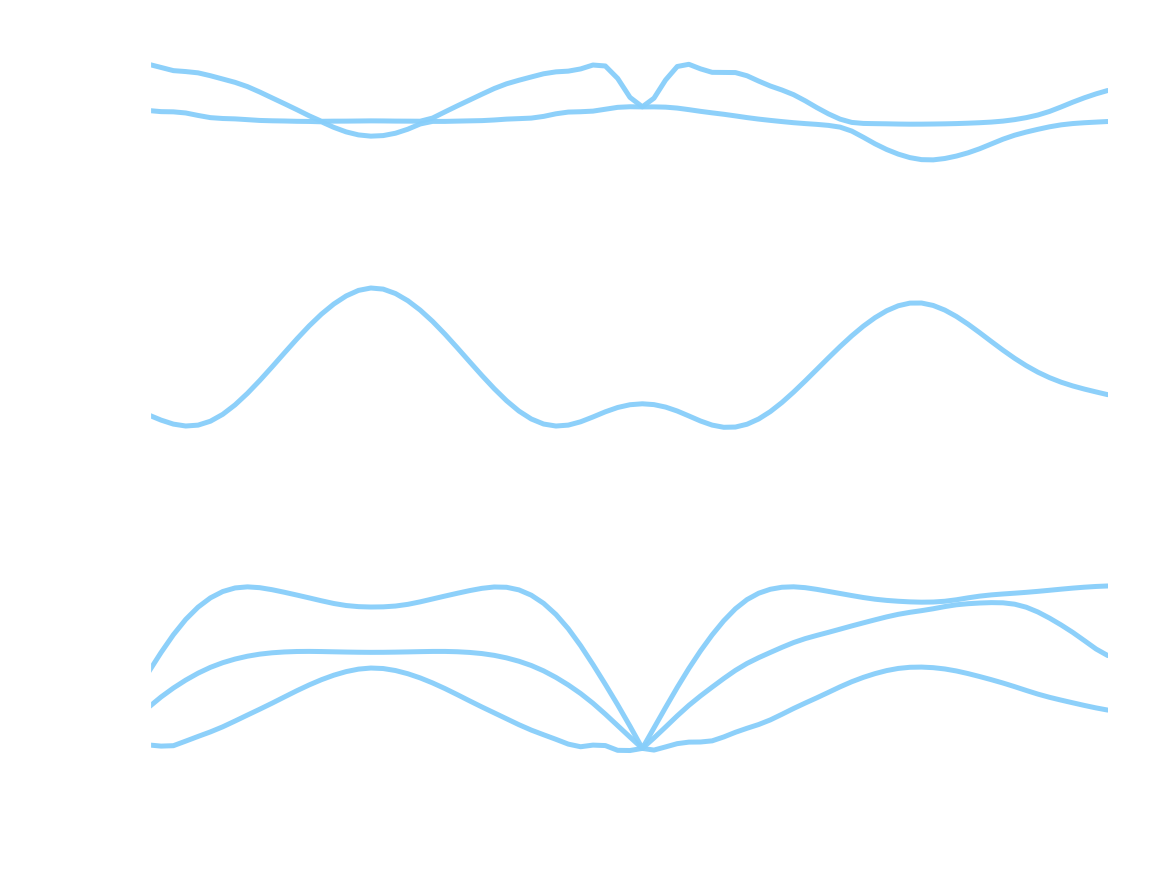

In [11]:
#!/usr/bin/env python3
# Plot GNUBANDS con colores por rama, fondo transparente, texto blanco
# y ejes k etiquetados según %block BandLines (M -> Γ -> K)

import sys, math
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

# -------- CONFIG --------
INPUT_PATH  = Path("2D-GaAs.phonon-bands.111.dat")
OUTPUT_PNG  = Path("bands_plot.png")   # PNG con fondo transparente
OUTPUT_SVG  = Path("bands_plot.svg")   # SVG sin fondo
line_w      = 1.2
alpha       = 0.95
TEXT_COLOR  = "white"
OKABE_ITO = ["#0072B2","#D55E00","#009E73","#CC79A7",
             "#F0E442","#56B4E9","#E69F00","#000000"]

OKABE_ITO = ["lightskyblue","lightskyblue","lightskyblue","lightskyblue",
             "lightskyblue","lightskyblue","lightskyblue","lightskyblue"]
# --- K-path para etiquetas, en el orden de tus tramos ---
# (n_puntos, (kx,ky,kz), etiqueta)  -> sólo usamos n_puntos y etiqueta
BANDLINES = [
    (1,   (0.5,  0.0,  0.0),  "M"),          # Start at M
    (40,  (0.0,  0.0,  0.0),  r"$\Gamma$"),  # M -> Γ
    (40,  (1/3,  1/3,  0.0),  "K"),          # Γ -> K
]

# ---------- Helpers ----------
def parse_blocks(text: str):
    """Divide el archivo en segmentos (k, E) por líneas en blanco/no numéricas."""
    segments, current = [], []
    for raw in text.splitlines():
        s = raw.strip()
        if not s or s.startswith('#') or set(s) == {'-'}:
            if current:
                segments.append(current); current = []
            continue
        vals=[]
        for p in s.split():
            try: vals.append(float(p))
            except ValueError: pass
        if len(vals) >= 2 and math.isfinite(vals[0]) and math.isfinite(vals[1]):
            current.append((vals[0], vals[1]))
        else:
            if current:
                segments.append(current); current = []
    if current: segments.append(current)
    return segments

def load_text(path: Path) -> str:
    if path.exists(): return path.read_text(encoding="utf-8", errors="ignore")
    if not sys.stdin.isatty(): return sys.stdin.read()
    raise FileNotFoundError(f"Missing '{path}'. Proporciona el archivo o usa stdin.")

# ---------- Main ----------
def main():
    text = load_text(INPUT_PATH)
    segments = parse_blocks(text)
    if not segments:
        raise RuntimeError("No se encontraron segmentos numéricos (k, E).")

    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300,
        "font.size": 10, "axes.labelsize": 11,
        "xtick.labelsize": 9, "ytick.labelsize": 9,
        "axes.spines.top": False, "axes.spines.right": False,
        "axes.linewidth": 1.0, "mathtext.default": "regular",
        "text.color": TEXT_COLOR,
        "axes.labelcolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
    })

    fig, ax = plt.subplots(figsize=(3.8, 2.9))

    fig.patch.set_alpha(0.0)
    ax.set_facecolor("none")

    for side in ("left","bottom","right","top"):
        ax.spines[side].set_color(TEXT_COLOR)
    ax.tick_params(colors=TEXT_COLOR, direction="out", length=3.5, width=0.8)

    ax.set_prop_cycle(color=OKABE_ITO)

    for seg in segments:
        ks = [p[0] for p in seg]
        # Si ya está en eV, usa: Es = [p[1] for p in seg]
        Es = [p[1]/241.764 for p in seg]
        ax.plot(ks, Es, lw=line_w, alpha=alpha,
                solid_joinstyle="round", solid_capstyle="round")

    ax.axhline(0.0, ls="--", lw=0.9, color=TEXT_COLOR, alpha=0.6, zorder=0)
    ax.set_ylabel(r"$Frequency (THz)$ ")

    counts  = [b[0] for b in BANDLINES]          
    labels  = [b[2] for b in BANDLINES]         

    ks_master = [p[0] for p in segments[0]]      # malla k del primer segmento
    total_needed = sum(counts)

    if len(ks_master) >= total_needed:
        # índices de cierre por tramo: cumsum(counts)-1
        cum, s = [], 0
        for c in counts:
            s += c
            cum.append(s-1)

        x_positions = [ks_master[0]] + [ks_master[i] for i in cum[1:]]
        x_end = ks_master[total_needed-1]
    else:
        x_min, x_max = ks_master[0], ks_master[-1]
        if x_max == x_min: x_max = x_min + 1.0
        x_positions = [x_min, (x_min+x_max)/2, x_max]
        x_end = x_max

    xtick_pos = list(x_positions)
    xtick_lab = list(labels)
    if not xtick_pos or abs(x_end - xtick_pos[-1]) > 1e-12:
        xtick_pos.append(x_end)
        xtick_lab.append("")

    ax.xaxis.set_major_locator(FixedLocator(xtick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(xtick_lab))

    for x in xtick_pos[1:]:
        ax.axvline(x, lw=0.8, ls="-", color=TEXT_COLOR, alpha=0.25, zorder=0)

    # ax.set_xlabel(r"$\mathrm{M}\!\rightarrow\!\Gamma\!\rightarrow\!\mathrm{K}$")
    x_min = xtick_pos[0]        
    x_max = xtick_pos[-1]       
    ax.set_xlim(x_min, x_max)
    
    ax.grid(False)
    fig.tight_layout(pad=0.6)
    fig.savefig(OUTPUT_PNG, bbox_inches="tight", transparent=True)
    fig.savefig(OUTPUT_SVG, bbox_inches="tight")
    print(f"Saved: {OUTPUT_PNG.resolve()}\nSaved: {OUTPUT_SVG.resolve()}")

if __name__ == "__main__":
    main()
